<a href="https://colab.research.google.com/github/ELFADLFINTECH/Forcasting_with_prophet/blob/main/Salt_pay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SaltPay

The aim is to: 
* Predict the sales per merchant per day for the next 3 months!

Guidance:
* Simply run the following code, where x represent a merchant_id:
       
```
 prophet_model(x)
```

Notes:
* There will be a list of merchant_id numbers to choose from.
* I used the prophet forecasting model for this project.


In [4]:
pip install pystan==2.19.1.1

In [5]:
!pip install prophet

     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 214 kB 59.0 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640320 sha256=5a5288030bd2034893f0416761d76175751dff649404dee7610ef36c8e24664e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [6]:
# First step is to import all needed libraries for the project:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
import prophet
#from prophet import Prophet
from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#Load data
from google.colab import files
uploaded=files.upload()

Saving Salt_transactions.xlsx to Salt_transactions.xlsx


In [16]:
# Second step is to read the file
import io
df = pd.read_excel (io.BytesIO(uploaded['Salt_transactions.xlsx']))
df.head(5)

,merchant_id,terminal_id,transaction_create_date,transaction_id,transaction_total_amount,merchant_registration_date,has_loyalty,transaction_currency,transaction_tip_amount,transaction_account_type
0,17,5589368,2021-01-20 15:02:00,25707962,9060,2020-08-13 22:31:00,NaN,ISK,0.0,Debit
1,17,5589368,2020-09-22 15:03:00,2857362,4500,2020-08-13 22:31:00,NaN,ISK,0.0,NaN
2,17,5589368,2021-05-10 15:33:00,51950962,6370,2020-08-13 22:31:00,NaN,ISK,0.0,Debit
3,17,5589368,2021-05-10 16:53:00,51999387,11330,2020-08-13 22:31:00,NaN,ISK,0.0,Debit
4,17,5589368,2021-05-10 18:19:00,52037737,1500,2020-08-13 22:31:00,NaN,ISK,0.0,Debit


In [17]:
# EDA: Detailed exploratory data step
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262771 entries, 0 to 262770
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   merchant_id                 262771 non-null  int64         
 1   terminal_id                 262771 non-null  int64         
 2   transaction_create_date     262771 non-null  datetime64[ns]
 3   transaction_id              262771 non-null  int64         
 4   transaction_total_amount    262771 non-null  int64         
 5   merchant_registration_date  262771 non-null  datetime64[ns]
 6   has_loyalty                 90549 non-null   object        
 7   transaction_currency        262771 non-null  object        
 8   transaction_tip_amount      262606 non-null  float64       
 9   transaction_account_type    224541 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 20.0+ MB


(262771, 10)

Since we are looking to predict sales (in a time series format) 
   * 1) per merchant 
   * 2) per day 
   * 3) for three months
   
We will need the following columns: 
   * merchant_id (the merchants)
   * transaction_create_date (transactions date)
   * transaction_total_amount (transactions amount)

##**EDA: Exploratory Data Analysis**# 

In [18]:
#Thus some processing is needed:
#1) transferring types of used columns
df['transaction_total_amount']=df['transaction_total_amount'].astype(float)

In [22]:
#Selecting only the needed columns
daily_sales = df.groupby('transaction_create_date', as_index=False)['transaction_total_amount'].sum()
merchants_daily_sales = df.groupby(['merchant_id', 'transaction_create_date'], as_index=False)['transaction_total_amount'].sum()
merchants_daily_sales.head()

,merchant_id,transaction_create_date,transaction_total_amount
0,2,2020-09-03 14:28:00,449.0
1,2,2020-09-03 14:30:00,570.0
2,2,2020-09-03 14:50:00,395.0
3,2,2020-09-03 14:52:00,395.0
4,2,2020-09-03 15:02:00,525.0


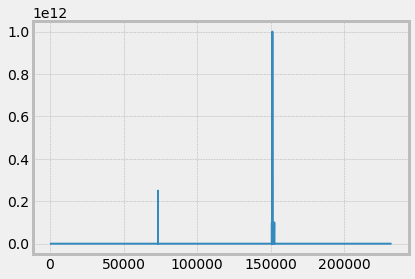

In [25]:
merchants_daily_sales["transaction_total_amount"].plot()


1. **Missing values**
2.   **Duplicates**
3.   **Outliers**



In [27]:
#Checking for missing values,
#1) missing values 
merchants_daily_sales.isnull().sum()

merchant_id                 0
transaction_create_date     0
transaction_total_amount    0
dtype: int64

In [32]:
#Checking for duplicates
merchants_daily_sales.duplicated().sum()

0

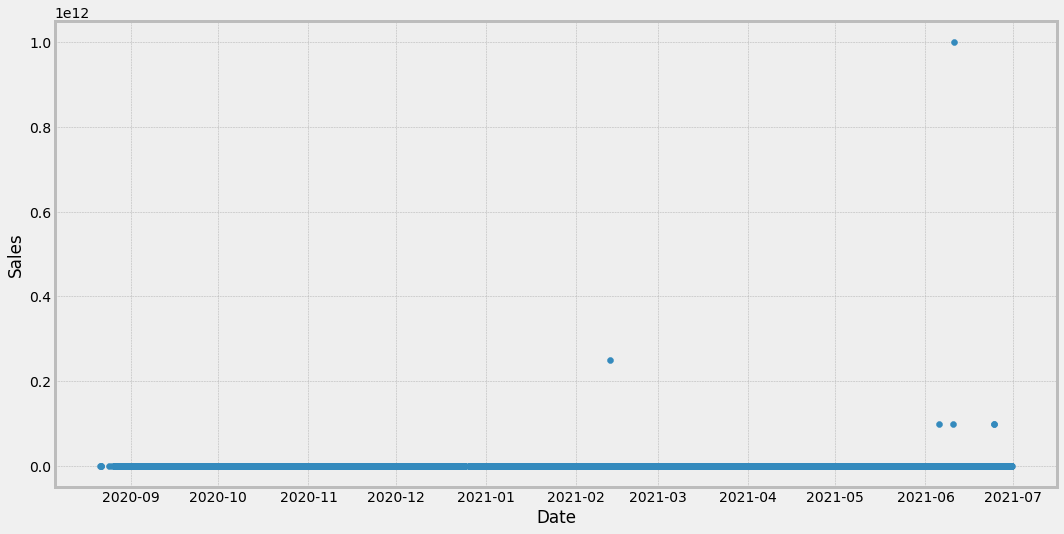

In [33]:
#Checking for Outliers
#Detecting Outliers
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter( merchants_daily_sales['transaction_create_date'],merchants_daily_sales['transaction_total_amount'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

In [34]:
#removing outliers
from scipy import stats
merchants_daily_sales2=merchants_daily_sales[(np.abs(stats.zscore(merchants_daily_sales['transaction_total_amount'])) < 3)]

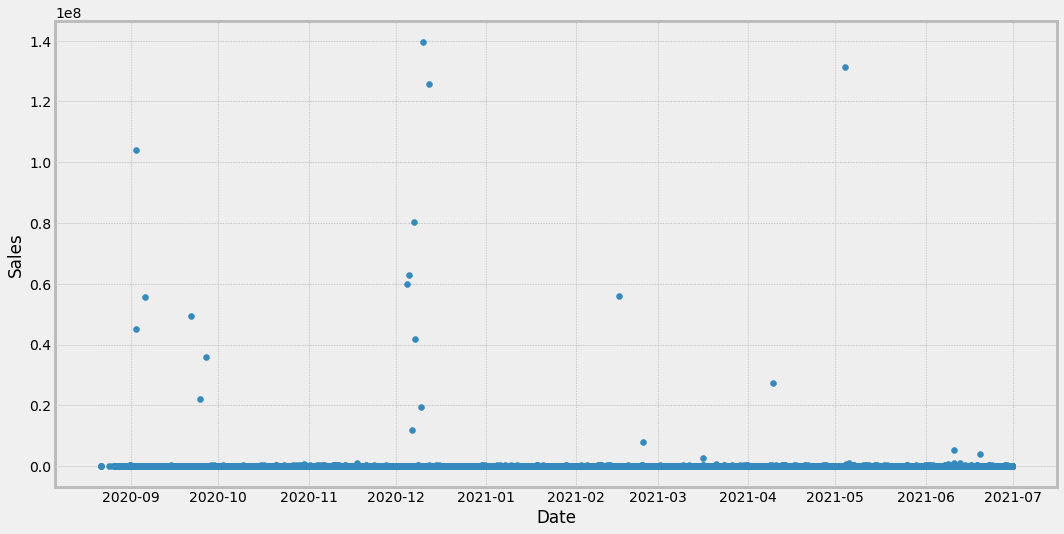

In [35]:
#cleaned data
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter( merchants_daily_sales2['transaction_create_date'],merchants_daily_sales2['transaction_total_amount'])
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()
#still better than the previous output

In [40]:
# slice the merchants id to smooth the process using a definition
def merchant_id(x):
    grouped = merchants_daily_sales2.groupby(merchants_daily_sales2.merchant_id)
    m_id = grouped.get_group(x)
    #mid= df.drop['merchant_id']    
    return (m_id)

# filter definition to show transaction per day 
def filtering(x):
    df2=merchant_id(x) #benefit from the previous definition
    #set date as an index
    df2.set_index('transaction_create_date',inplace=True)
    df2=df2.drop(columns=['merchant_id'])
    df2=df2.resample('D').sum()
    df2=df2.dropna()
    return (df2)
    

In [52]:
#list of all the merchants id:
row_values = df['merchant_id'].values.ravel()
unique_values =  pd.unique(row_values)

print("Choose form", unique_values)

Choose form [  17  719  103  100   11  456   80   33    2   10   75   20  165  188
    9   56 1006   14   12]


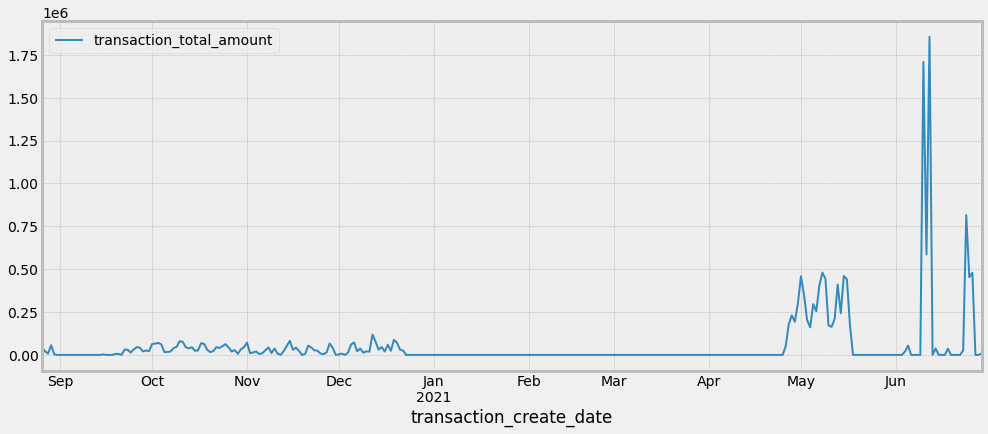

In [43]:
filtering(17).plot(figsize=(15, 6))
#plt.show()

In [61]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 


def prophet_model(y):
  # preparing the data into FBP format:
  row_values = df['merchant_id'].values.ravel()
  unique_values =  pd.unique(row_values)
  print(" List of merchant_ids to choose from", unique_values)
  df3 = filtering(y)
  df3.reset_index(level=0, inplace=True)
  df3.columns = ["ds", "y"]
  m = Prophet(interval_width=0.95, daily_seasonality=True)
  model = m.fit(df3)
  future = m.make_future_dataframe(periods=90,freq='D')
  forecast = m.predict(future)
  plot1 = m.plot(forecast)
  plt2 = m.plot_components(forecast)
 # The black dots reps the real data and the blue lines and shades reps the possibilites 

 List of merchant_ids to choose from [  17  719  103  100   11  456   80   33    2   10   75   20  165  188
    9   56 1006   14   12]


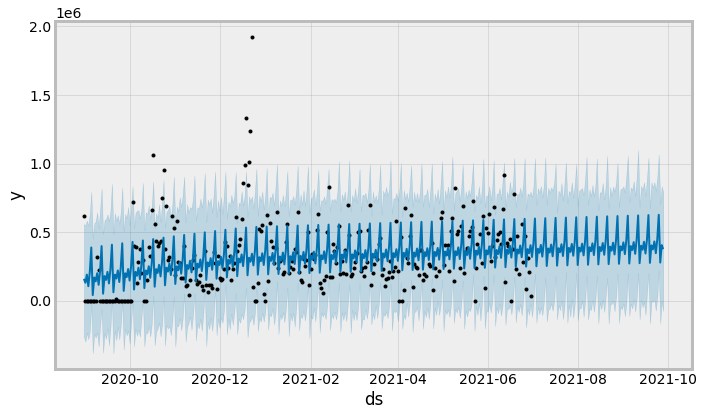

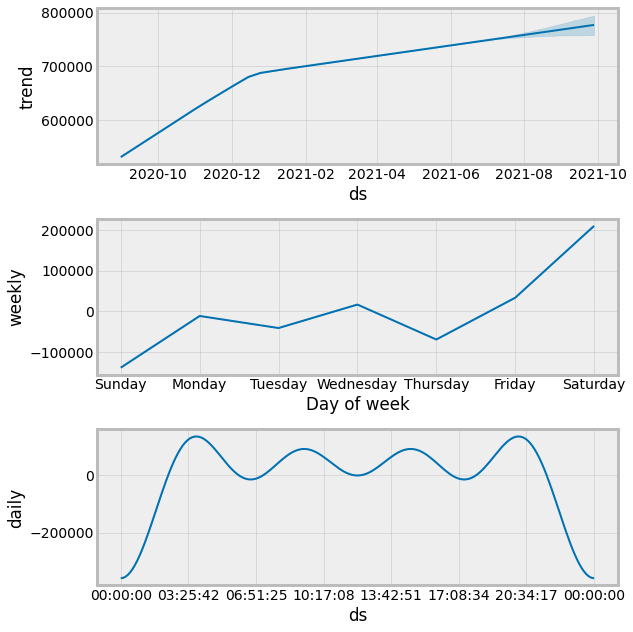

In [68]:
#Example and the list of choices is linked as well: prophet_model(17), prophet_model(719)
prophet_model(17)